<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Raw-data" data-toc-modified-id="Raw-data-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Raw data</a></span></li></ul></li><li><span><a href="#Accelerometer-data" data-toc-modified-id="Accelerometer-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Accelerometer data</a></span><ul class="toc-item"><li><span><a href="#Finding-the-orientation-of-the-accelerometers" data-toc-modified-id="Finding-the-orientation-of-the-accelerometers-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Finding the orientation of the accelerometers</a></span></li><li><span><a href="#Removing-bias" data-toc-modified-id="Removing-bias-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Removing bias</a></span></li><li><span><a href="#Removing-high-frequency-noise" data-toc-modified-id="Removing-high-frequency-noise-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Removing high frequency noise</a></span></li></ul></li><li><span><a href="#Gyro-data" data-toc-modified-id="Gyro-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Gyro data</a></span><ul class="toc-item"><li><span><a href="#Removing-drift" data-toc-modified-id="Removing-drift-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Removing drift</a></span></li><li><span><a href="#Compensating-for-the-rotation-of-accelerometer-sensor" data-toc-modified-id="Compensating-for-the-rotation-of-accelerometer-sensor-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Compensating for the rotation of accelerometer sensor</a></span></li></ul></li></ul></div>

In [251]:
import numpy as np 
import scipy as sci
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.ndimage.interpolation import rotate
from scipy.signal import filtfilt
from scipy.signal import butter

In [252]:
data1 = np.loadtxt("Time_AccX_AccY_yaw_theta1.txt", delimiter=",")
data2 = np.loadtxt("Time_AccX_AccY_yaw_theta2.txt", delimiter=",")

In [253]:
def unpack_data(data):
    time = data[0]
    AccX = data[1]
    AccY = data[2]
    yaw = data[3]
    return time, AccX, AccY, yaw

def find_drift(time, yaw):
    peaks = find_peaks(yaw, 25)[0]
    t = time[peaks]
    y = yaw[peaks]
    line = sci.stats.linregress(t, y)
    return line

def remove_drift(data):
    time, AccX, AccY, yaw = unpack_data(data)
    line = find_drift(time, yaw)
    line_f = lambda x: line.slope*x
    return yaw - line_f(time)

def plot_both(x, y):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(x[0], y[0])
    ax2.plot(x[1], y[1])

## Raw data

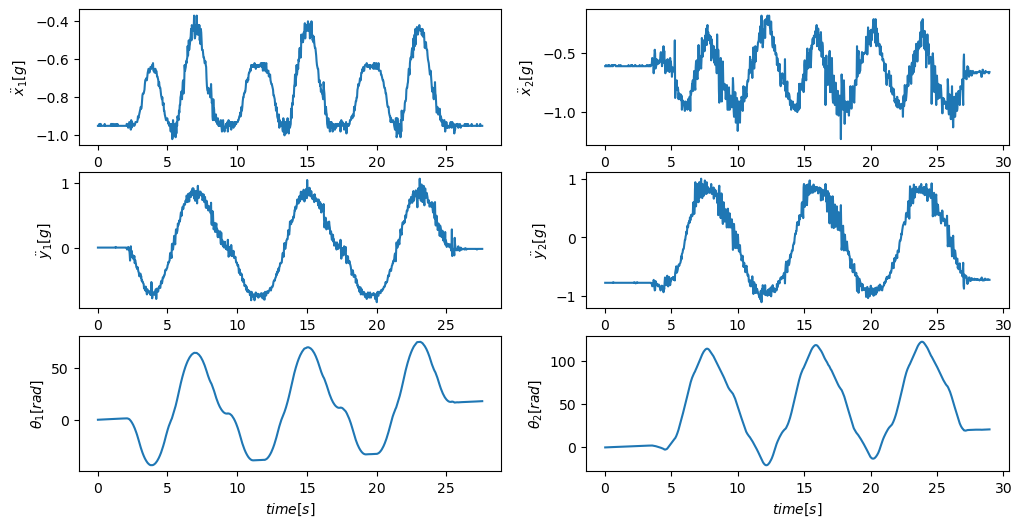

In [254]:
data1 = np.loadtxt("Time_AccX_AccY_yaw_theta1.txt", delimiter=",").T
data2 = np.loadtxt("Time_AccX_AccY_yaw_theta2.txt", delimiter=",").T
data1[0] /= 1e6
data2[0] /= 1e6


time1, AccX1, AccY1, yaw1 = unpack_data(data1)
time2, AccX2, AccY2, yaw2 = unpack_data(data2)


fig, axs = plt.subplots(3, 2, figsize=(12,6))
for i, data in enumerate([data1, data2]):
    axs[0, i].plot(data[0], data[1])
    axs[0, i].set_xlabel(r"$time [s]$")
    axs[0, i].set_ylabel(f"$\ddot x_{i+1}[g]$")
    axs[1, i].set_xlabel(r"$time [s]$")
    axs[1, i].plot(data[0], data[2])
    axs[1, i].set_ylabel(f"$\ddot y_{i+1}[g]$")
    axs[2, i].plot(data[0], data[3])
    axs[2, i].set_xlabel(r"$time [s]$") 
    axs[2, i].set_ylabel(f"$\\theta_{i+1}[rad]$")

# Gyro data

## Removing drift

Gyroscopes have a constant drift that should be removed from the signal. To do so we measure the slope between the periodic peaks of the signal and deduct this proportional function from the signal

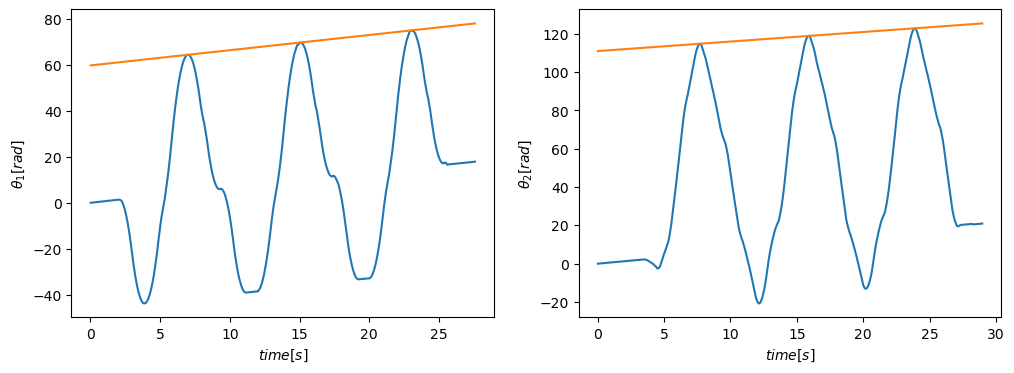

In [255]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].set_xlabel("$time [s]$")
axs[1].set_xlabel("$time [s]$")
axs[0].set_ylabel("$\\theta_1 [rad]$")
axs[1].set_ylabel("$\\theta_2 [rad]$")
for i, data in enumerate([data1, data2]):
    time, AccX, AccY, yaw = unpack_data(data)
    line = find_drift(time, yaw)
    line_f = lambda x: line.slope*x + line.intercept
    axs[i].plot(data[0], data[-1])
    axs[i].plot(data[0], line_f(data[0]))

After removing drift:

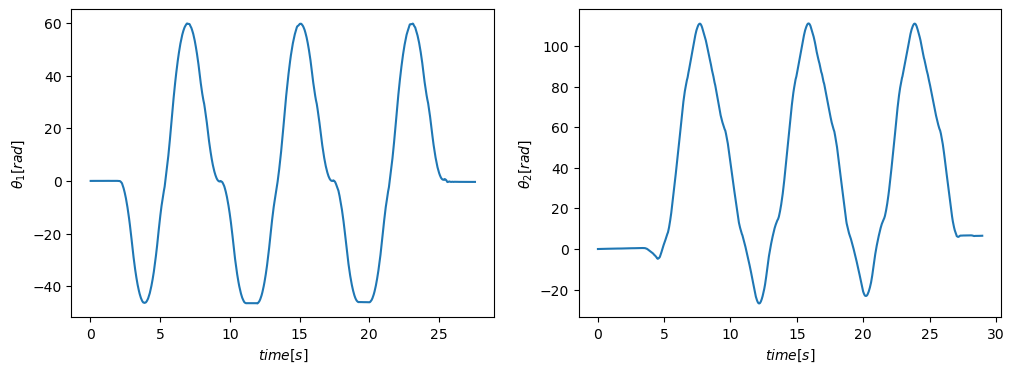

In [256]:
data1[-1] = remove_drift(data1)
data2[-1] = remove_drift(data2)
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].set_xlabel("$time [s]$")
axs[1].set_xlabel("$time [s]$")
axs[0].set_ylabel("$\\theta_1 [rad]$")
axs[1].set_ylabel("$\\theta_2 [rad]$")

for i, data in enumerate([data1, data2]):
    axs[i].plot(data[0], data[-1])

In [257]:
for data in [data1, data2]:
    angle = orientation(data)
    R = np.array([
        [np.cos(angle), -np.sin(angle)],
        [np.sin(angle), np.cos(angle)]
    ])
    data[1:3] = R@data[1:3]

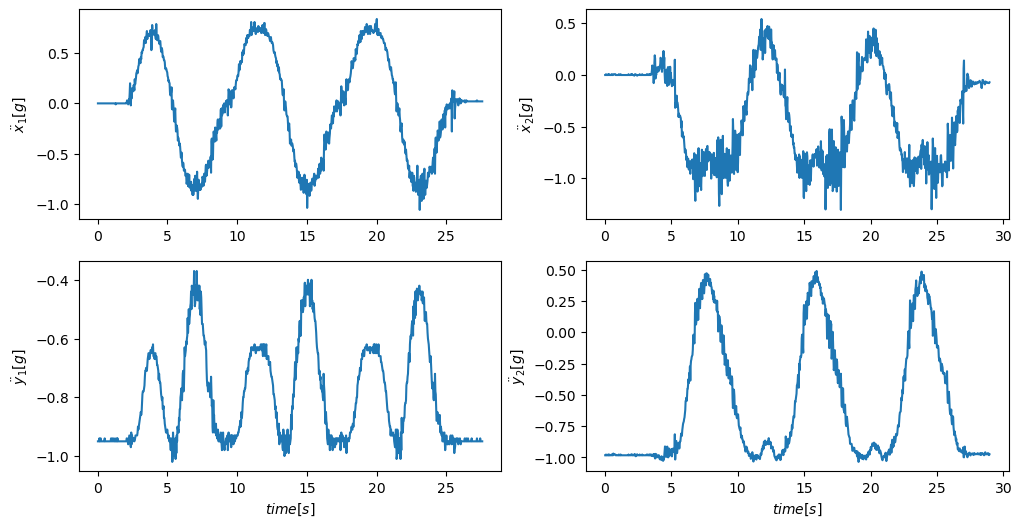

In [258]:
fig, axs = plt.subplots(2, 2, figsize=(12,6))
for i, data in enumerate([data1, data2]):
    axs[0, i].plot(data[0], data[1])
    axs[0, i].set_ylabel(f"$\ddot x_{i+1}[g]$")
    axs[1, i].set_xlabel(r"$time [s]$")
    axs[1, i].plot(data[0], data[2])
    axs[1, i].set_ylabel(f"$\ddot y_{i+1}[g]$")

# Accelerometer data

## Finding the orientation of the accelerometers
the first flat part of the acceleration signal represents steady state. At this state we would want the acceleration from gravity to point in the negative y direction.
To accomplish this we find apply a rotation to the x and y acceleration data, such that gravity aligns with the y axis

In [259]:
def orientation(data):
    time = data[0]
    xy = np.array([
        np.average(data[1][np.nonzero(time<2)[0]]),
        np.average(data[2][np.nonzero(time<2)[0]])
        ])
    goal_orient = np.array([
        0,
        -1])  #we want acceleration to point towards negative y

    angle = np.arccos(xy@goal_orient/(np.linalg.norm(xy)*np.linalg.norm(goal_orient)))
    return angle

## Removing bias


the first part of the acceleration signals are in steady state, and so should be zero (if we want to exclude the effect of gravity). we can deduct this bias error from the signal

In [260]:
def remove_y_bias(data):
    bias = np.average(data[2][np.nonzero(data[0]<1)[0]])
    data[2] -= bias

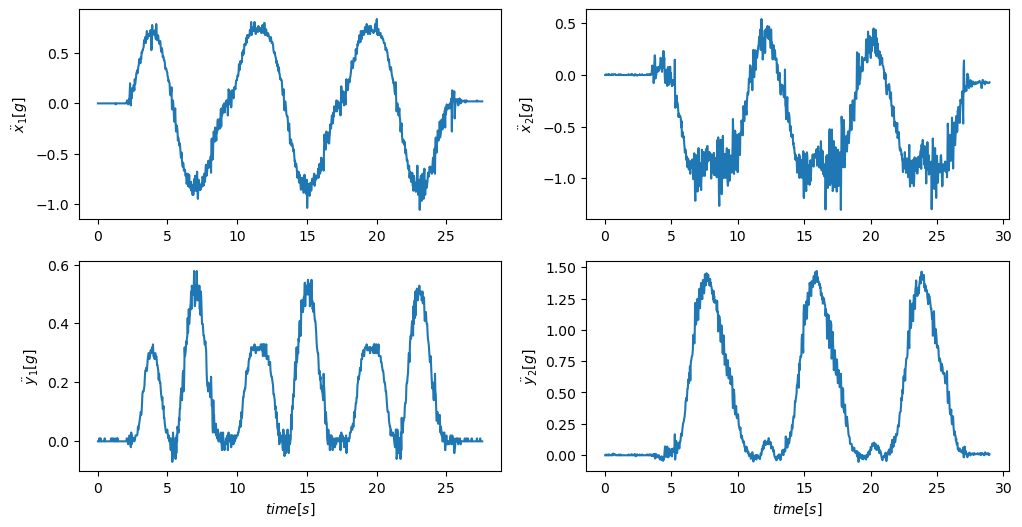

In [261]:
for data in [data1, data2]:
    remove_y_bias(data)

fig, axs = plt.subplots(2, 2, figsize=(12,6))
for i, data in enumerate([data1, data2]):
    axs[0, i].plot(data[0], data[1])
    axs[0, i].set_ylabel(f"$\ddot x_{i+1}[g]$")
    axs[1, i].set_xlabel(r"$time [s]$")
    axs[1, i].plot(data[0], data[2])
    axs[1, i].set_ylabel(f"$\ddot y_{i+1}[g]$")

## Removing high frequency noise
by applying a butterworth lowpass filter, we can remove some of the high frequency noise present in the signal

First we examine the fft of the signal to see where the cutoff frequency should lie

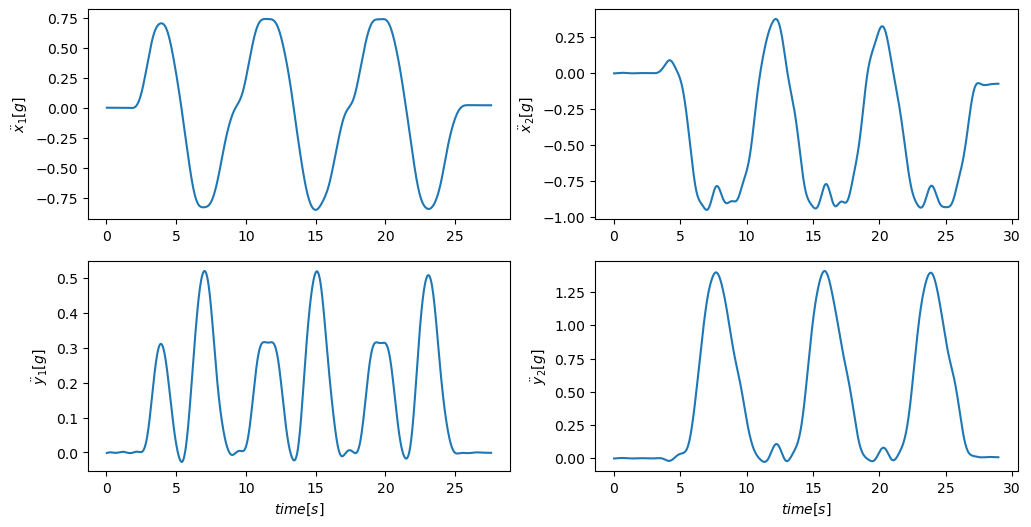

In [262]:
for data in [data1, data2]:
    for i in range(1, 3):
        fs = np.average(np.diff(data[0]))**(-1)  #samping frequency
        a, b = sci.signal.butter(5, 1, fs=fs)
        data[i] = sci.signal.filtfilt(a, b, data[i]) 

fig, axs = plt.subplots(2, 2, figsize=(12,6))
for i, data in enumerate([data1, data2]):
    axs[0, i].plot(data[0], data[1])
    axs[0, i].set_ylabel(f"$\ddot x_{i+1}[g]$")
    axs[1, i].set_xlabel(r"$time [s]$")
    axs[1, i].plot(data[0], data[2])
    axs[1, i].set_ylabel(f"$\ddot y_{i+1}[g]$")

# Gyro data

## Removing drift

Gyroscopes have a constant drift that should be removed from the signal. To do so we measure the slope between the periodic peaks of the signal and deduct this proportional function from the signal

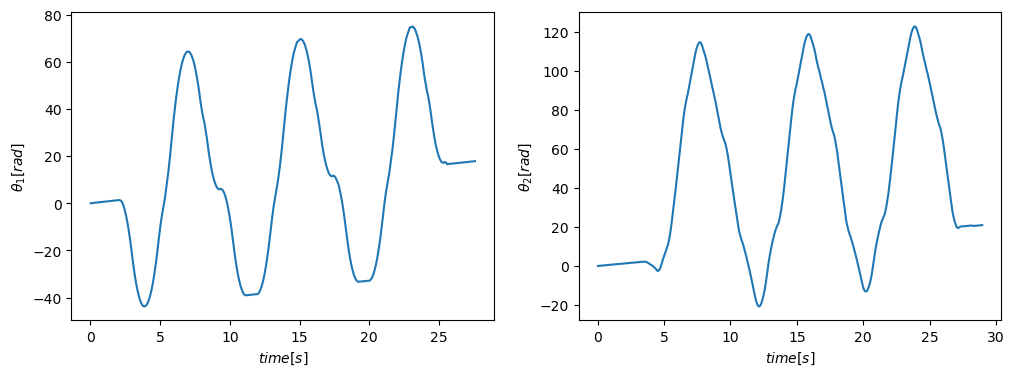

In [243]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].set_xlabel("$time [s]$")
axs[1].set_xlabel("$time [s]$")
axs[0].set_ylabel("$\\theta_1 [rad]$")
axs[1].set_ylabel("$\\theta_2 [rad]$")
for i, data in enumerate([data1, data2]):
    axs[i].plot(data[0], data[-1])

After removing drift:

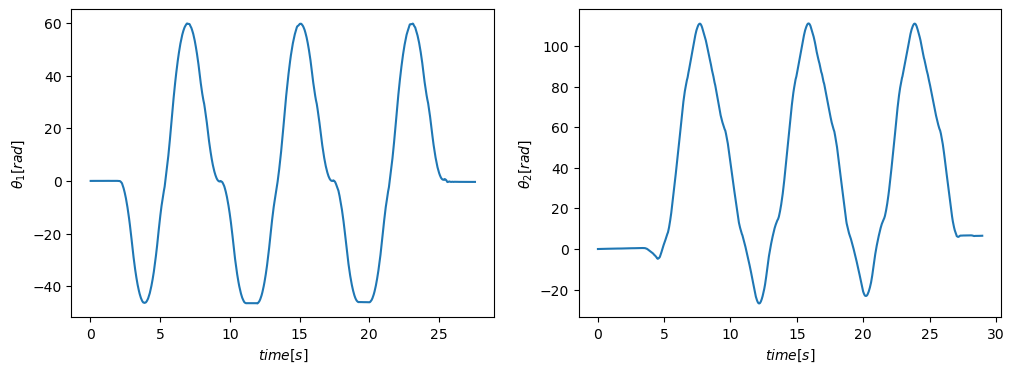

In [244]:
data1[-1] = remove_drift(data1)
data2[-1] = remove_drift(data2)
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].set_xlabel("$time [s]$")
axs[1].set_xlabel("$time [s]$")
axs[0].set_ylabel("$\\theta_1 [rad]$")
axs[1].set_ylabel("$\\theta_2 [rad]$")

for i, data in enumerate([data1, data2]):
    axs[i].plot(data[0], data[-1])

## Compensating for the rotation of accelerometer sensor

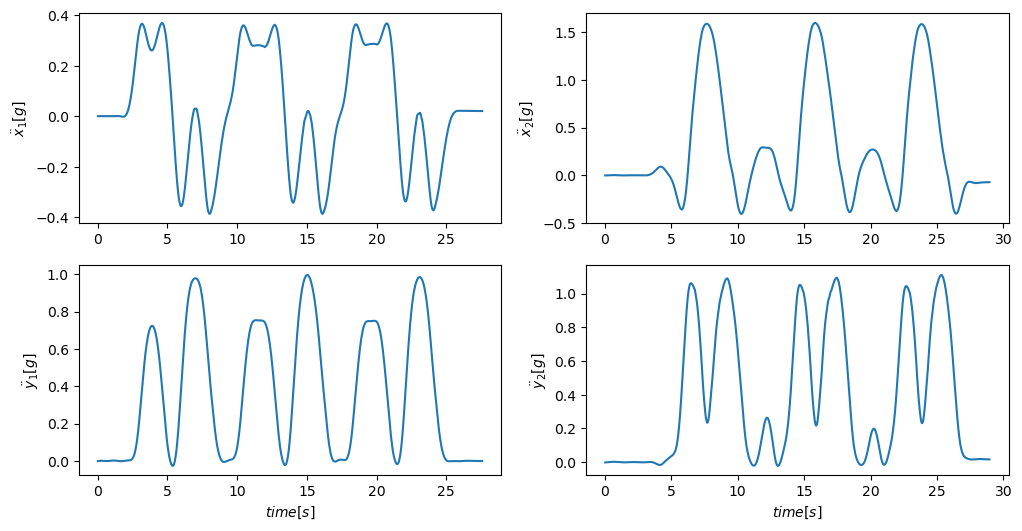

In [263]:
for data in [data1, data2]:
    for i in range(data.shape[1]):
        angle = data[-1,i]/180*np.pi
        R = np.array([
        [np.cos(angle), np.sin(angle)],
        [-np.sin(angle), np.cos(angle)]
        ])
        data[1:3,i] = R@data[1:3,i]

fig, axs = plt.subplots(2, 2, figsize=(12,6))
for i, data in enumerate([data1, data2]):
    axs[0, i].plot(data[0], data[1])
    axs[0, i].set_ylabel(f"$\ddot x_{i+1}[g]$")
    axs[1, i].set_xlabel(r"$time [s]$")
    axs[1, i].plot(data[0], data[2])
    axs[1, i].set_ylabel(f"$\ddot y_{i+1}[g]$")